In [1]:
local = False

# Type of input data
data_type = "spec" # "eeg_raw" #"eeg_spec"  #
# number of subprocesses to use for data loading
import multiprocessing as cpu
num_workers = cpu.cpu_count() #- 1
# how many samples per batch to load
batch_size = 64
# shuffle?
shuffle = True
# Is a test?
test = False

data_type, num_workers, batch_size, shuffle

('spec', 2, 8, True)

In [2]:
if not local:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if not local:
    %cd /content/drive/MyDrive/Sun/ML Shock/Final project/

/content/drive/MyDrive/Sun/ML Shock/Final project


In [4]:
# Load (train or test) data from csv file
if local:
    path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/sample_data/"
    path_df = "C:/Users/Amy/Desktop/Green_Git/eegClassification/files/"
else:
    path = "./data/"
    path_df = "./"


In [5]:
import sys
if local:
    sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
else:
    sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [6]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import torch

from CustomDataLoader import CustomDataset
from torch.utils.data import DataLoader

In [7]:
if data_type == "spec":
    input_shape = (4,299,100)
elif data_type == "eeg_spec":
    input_shape = (20,129,43)
elif data_type == "eeg_raw":
    input_shape = (20,9800)

In [8]:
def get_data_info(df, data_type):

    votes_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]

    # train is true id votes_cols are available
    train = all([col in df.columns for col in votes_cols])

    label_cols = (
        ["eeg_id", "label_id", "eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_id", "label_id", "spectrogram_label_offset_seconds"]
    )
    offset = (
        ["eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_label_offset_seconds"]
    )

    # if info_cols not in df add it and set to zero
    for col in offset:
        if col not in df.columns:
            df[col] = 0
    # if df does not contain "label_id" add a unique label_id
    if "label_id" not in df.columns:
        df["label_id"] = range(len(df))

    info = {}
    df_gr = df.groupby(label_cols)
    for name, group in df_gr:
        # first row of group
        info[name] = {"votes": group[votes_cols].values[0] if train else None}

    return info

In [9]:
data_dir = (
        f"train_eegs/"
        if "eeg" in data_type
        else f"train_spectrograms/"
    )
data_dir = path + data_dir


In [10]:
for text in ["train", "val", "test"]:
    df = pd.read_csv(path_df + f"{text}_processed.csv")

    if local:
        # When running on a testing sample
        files = os.listdir(data_dir)
        df = df[
            df["eeg_id" if "eeg" in data_type else "spectrogram_id"].isin(
                [int(f.split(".")[0]) for f in files]
            )
        ]
        ##

    info = get_data_info(df, data_type)
    data_dir, data_type, len(info)

    dataset = CustomDataset(data_dir, data_type, info)
    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
    )

    save_path = f"./data_prep_all_{data_type}/{text}/"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # loop through data and save it as a numpy array
    count = 0
    for X, label, votes in tqdm(data_loader, desc=f"Saving {text} data"):
        # save the images
        np.save(save_path + f"images_{count}.npy", X.numpy())
        # save the votes
        np.save(save_path + f"votes_{count}.npy", votes.numpy())

        count += 1

        if test and count > 1:
            break

Saving train data:   0%|          | 10/8189 [02:28<33:41:13, 14.83s/it]


KeyboardInterrupt: 

In [11]:
# load npy file
img = np.load("./data_prep_all_spec/train/images_0.npy")
print(img.shape)

img = torch.tensor(img)

(8, 3, 400, 299)


In [12]:
print(torch.mean(img.reshape(batch_size, 3, -1), axis = -1), torch.std(img.reshape(batch_size,3, -1), axis = -1))

tensor([[-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060]]) tensor([[0.2290, 0.2240, 0.2250],
        [0.2290, 0.2240, 0.2250],
        [0.2290, 0.2240, 0.2250],
        [0.2290, 0.2240, 0.2250],
        [0.2290, 0.2240, 0.2250],
        [0.2290, 0.2240, 0.2250],
        [0.2290, 0.2240, 0.2250],
        [0.2290, 0.2240, 0.2250]])


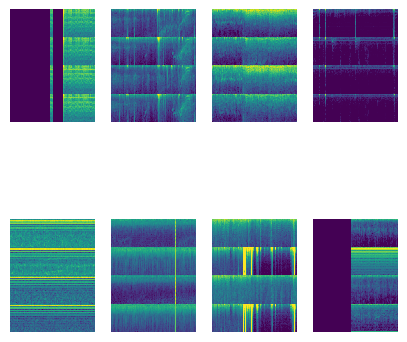

In [13]:

# show batch of images
fig, ax = plt.subplots( batch_size//4,4, figsize = (5,5))
for i in range(batch_size//4):
    for j in range(4):
        ax[i,j].imshow(img[i*4+j,0], interpolation='none')
        ax[i,j].axis("off")